# <center><span style="color:#CD2121"><u> SDA - Projet 4 Classification :</u><br><br> <span><span style="color:#191970">Prédire le parti victorieux de chaque Etat US aux élections de 2020 <br>~ Partie 2/2 ~<br><br>*Anne & Julie*
***

In [1]:
%reset -f

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,
    cross_val_predict,
    cross_validate
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (
    f1_score
)
import xgboost as xgb
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import classification_report

## <span style="color:#191970">3. Modélisation</span>

In [5]:
#import du df nettoyé
df_train_prepro = pd.read_csv('data\outputs\df_train_prepro.csv', sep=',')
df_train_prepro.head()

,FIPS Code,State_x,Area name,2013 Rural-urban Continuum Code,"Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults completing some college or associate's degree, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",PCTPOVALL_2019,Unemployment_rate_2019,Med_HH_Income_Percent_of_State_Total_2019,POP_ESTIMATE_2019,N_POP_CHG_2019,R_NATURAL_INC_2019,R_INTERNATIONAL_MIG_2019,R_NET_MIG_2019,target
0,39061,OH,Hamilton County,1.0,8.628272,26.287451,27.164076,37.920200,14.6,3.8,102.635254,817473.0,2028.0,3.433118,1.311762,-0.906353,0.0
1,28083,MS,Leflore County,5.0,18.378925,38.162109,24.978935,18.480032,35.7,7.5,64.638130,28183.0,-433.0,1.725382,-0.176059,-17.007342,0.0
2,37087,NC,Haywood County,2.0,11.997293,26.363478,35.651283,25.987947,10.6,3.4,89.935181,62317.0,427.0,-2.882285,-0.370349,9.774006,1.0
3,20029,KS,Cloud County,7.0,7.048825,31.561407,37.427097,23.962673,13.5,3.2,74.642097,8786.0,52.0,-2.968037,0.570776,9.018265,1.0
4,38013,ND,Burke County,9.0,7.409880,27.770361,42.056076,22.763685,8.8,2.3,100.212158,2115.0,21.0,4.276550,0.000000,5.702067,1.0


### <span style="color:#191970">3.1. Mise en forme des données pour l'entrainement</span>

In [6]:
df_train_prepro['target'].value_counts()

1.0    2054
0.0     437
Name: target, dtype: int64

In [7]:
df_train_prepro['target'].value_counts(normalize=True)

1.0    0.824568
0.0    0.175432
Name: target, dtype: float64

In [8]:
df_train_prepro['State_x'].value_counts()

TX    204
GA    127
VA    107
KY     96
MO     92
KS     84
IL     82
NC     80
IA     79
TN     76
NE     74
IN     74
OH     71
MN     69
MI     66
MS     65
OK     61
AR     61
WI     57
PA     53
SD     53
FL     53
AL     53
CO     52
LA     52
NY     49
CA     46
MT     45
WV     44
ND     42
SC     37
ID     36
WA     31
OR     29
NM     26
UT     24
MD     19
WY     19
NJ     17
NV     14
ME     13
VT     12
AZ     12
MA     11
NH      8
CT      6
RI      4
HI      3
DE      2
DC      1
Name: State_x, dtype: int64

In [9]:
comptage = df_train_prepro.groupby(['State_x', 'target']).count()

In [10]:
comptage['FIPS Code'].head(30)

State_x  target
AL       0.0        11
         1.0        42
AR       0.0         6
         1.0        55
AZ       0.0         4
         1.0         8
CA       0.0        28
         1.0        18
CO       0.0        18
         1.0        34
CT       0.0         6
DC       0.0         1
DE       0.0         2
FL       0.0        10
         1.0        43
GA       0.0        25
         1.0       102
HI       0.0         3
IA       0.0         6
         1.0        73
ID       0.0         1
         1.0        35
IL       0.0        10
         1.0        72
IN       0.0         4
         1.0        70
KS       0.0         4
         1.0        80
KY       0.0         2
         1.0        94
Name: FIPS Code, dtype: int64

In [11]:
y_train = df_train_prepro['target'].values
X_train = df_train_prepro.drop(columns=['target'])

### <span style="color:#191970">3.2. Préparation pipeline</span>

In [12]:
SEED = 0

standard_scaler = StandardScaler() #pour standardiser les échelles 
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore') #OHE car les variables catégorielles se sont pas ordinales

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical_code", standard_scaler, make_column_selector(dtype_include=np.int64)),
        ("numerical_var", standard_scaler, make_column_selector(dtype_include=np.float64)),
        ("categorical", one_hot_encoder, make_column_selector(dtype_include=object))        
    ], remainder="passthrough"
)

### <span style="color:#011C5D">3.3. Pré-sélection de modèles</span>

In [13]:
clf_candidates = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=SEED),
    "Random Forest": RandomForestClassifier(random_state=SEED),
    "Gradient boosting": GradientBoostingClassifier(random_state=SEED),
    "Decision Tree": DecisionTreeClassifier(random_state=SEED),
    "SVM with polynomial kernel": svm.SVC(kernel="poly", degree=3, random_state=SEED),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, n_jobs=5)
}
results = []
for clf_name in clf_candidates:
    pipe = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', clf_candidates[clf_name])
    ])
    y_train_pred = cross_val_predict(pipe, X_train, y_train, 
                                     cv=5, n_jobs=5)
    f1 = f1_score(y_train, y_train_pred)
    results.append(round(f1*100,2))
    print(f"{clf_name}: {round(f1*100,2)} %")

f1_score_avt_gscv = pd.DataFrame({'f1_score_avt_grid': results},
                          index = ['Logistic Regression', 'Random Forest', 'Gradient boosting', 'Decision Tree', 'SVM', 'XGBoost'] 
                          )

Logistic Regression: 94.78 %
Random Forest: 94.21 %
Gradient boosting: 94.49 %
Decision Tree: 92.42 %
SVM with polynomial kernel: 94.15 %
XGBoost: 94.75 %


In [14]:
print(f1_score_avt_gscv)

                     f1_score_avt_grid
Logistic Regression              94.78
Random Forest                    94.21
Gradient boosting                94.49
Decision Tree                    92.42
SVM                              94.15
XGBoost                          94.75


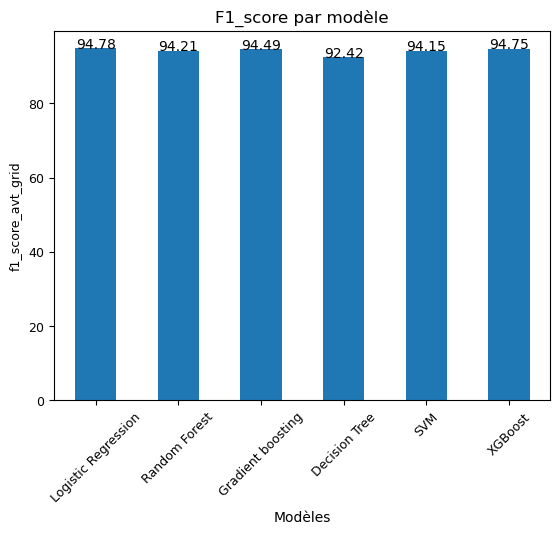

In [15]:
# Représentation F1_score par modèle

def add_value_label(x_list,y_list):
    for i in range(0, len(x_list)):
        plt.text(i,y_list[i],y_list[i], ha="center")

list_f1_score = results
modeles = ['Logistic Regression','Random Forest','Gradient boosting','Decision Tree','SVM','XGBoost']

plt.title("F1_score par modèle")
f1_score_avt_gscv['f1_score_avt_grid'].plot.bar(rot=45,fontsize=9)
add_value_label(modeles,list_f1_score)
plt.ylabel("f1_score_avt_grid",fontsize=9)
plt.xlabel("Modèles")
plt.show()

In [16]:
f1_score_avt_gscv_best = f1_score_avt_gscv.loc[["Logistic Regression", "Gradient boosting", "XGBoost"]]

In [17]:
# 3 meilleurs modèles :

f1_score_avt_gscv_best

,f1_score_avt_grid
Logistic Regression,94.78
Gradient boosting,94.49
XGBoost,94.75


### <span style="color:#011C5D">3.4. Optimisation modèles : Grid-search</span>

#### <span style="color:#011C5D">Regression logistique</span>

In [18]:
f1_score_ap_gscv = []

In [19]:
pipe_lr = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', LogisticRegression(max_iter = 1000, random_state = SEED))
    ])

param_grid_lr = {
    'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty':['l1', 'l2'],    
    'classifier__max_iter':[20, 50, 100, 200, 500, 1000],
    'classifier__solver':['lbfgs', 'saga'],
}
    
pipe_gscv_lr = GridSearchCV(pipe_lr, param_grid=param_grid_lr, scoring = "f1", 
                         cv=5, n_jobs=5, verbose=1)

pipe_gscv_lr.fit(X_train,y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical_code',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000029557F7C0D0>),
                                                                        ('numerical_var',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000029557F7...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000029557F7C8

In [20]:
f1_score_ap_gscv.append(round(pipe_gscv_lr.best_score_*100,2))

In [21]:
print(f"Le score F1, après optimisation des hyperparamètres, pour la regression logistique est de {round(pipe_gscv_lr.best_score_ *100,2)} %")
print(f"Les meilleurs hyperparamètres sont :")
print(pipe_gscv_lr.best_params_)

Le score F1, après optimisation des hyperparamètres, pour la regression logistique est de 94.94 %
Les meilleurs hyperparamètres sont :
{'classifier__C': 1, 'classifier__max_iter': 500, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}


#### <span style="color:#011C5D">Gradient boosting</span>

In [22]:
pipe_gb = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', GradientBoostingClassifier(random_state=SEED))
    ])

param_grid_gb = {
    'classifier__learning_rate': [0.01, 0.1, 1, 10],
    "classifier__n_estimators": [50, 100, 200, 500],
    "classifier__max_leaf_nodes": [2, 10, 50, 100]
}


pipe_gscv_gb = GridSearchCV(pipe_gb, param_grid=param_grid_gb, scoring="f1", 
                         cv=5, n_jobs=5, verbose=1)

pipe_gscv_gb.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical_code',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000029557F7C0D0>),
                                                                        ('numerical_var',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000029557F7...
                                                                                       handle_unknown='ignore'),
                                            

In [23]:
f1_score_ap_gscv.append(round(pipe_gscv_gb.best_score_*100,2))

In [24]:
print(f"Le score F1, après optimisation des hyperparamètres, pour le Gradient Boosting est de {round(pipe_gscv_gb.best_score_ *100,2)} %")
print(f"Les meilleurs hyperparamètres sont :")
print(pipe_gscv_gb.best_params_)

Le score F1, après optimisation des hyperparamètres, pour le Gradient Boosting est de 94.52 %
Les meilleurs hyperparamètres sont :
{'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 10, 'classifier__n_estimators': 200}


#### <span style="color:#011C5D">XGBoost</span>

In [25]:
pipe_xg = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', xgb.XGBClassifier(use_label_encoder=False, n_jobs=5))
    ])

param_grid_xg = {
    'classifier__max_depth': range (2, 10, 1),
    'classifier__n_estimators': range(60, 220, 40),
    'classifier__learning_rate': [0.1, 0.01, 0.05]
}

pipe_gscv_xg = GridSearchCV(pipe_xg, param_grid=param_grid_xg, scoring="f1", 
                         cv=5, n_jobs=5, verbose=1)

pipe_gscv_xg.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical_code',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000029557F7C0D0>),
                                                                        ('numerical_var',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000029557F7...
                                                      max_depth=None,
                                                      max_leaves=None,
                

In [26]:
print(f"Le score F1, après optimisation des hyperparamètres, pour le XGBoost est de {round(pipe_gscv_xg.best_score_ *100,2)} %")
print(f"Les meilleurs hyperparamètres sont :")
print(pipe_gscv_xg.best_params_)

Le score F1, après optimisation des hyperparamètres, pour le XGBoost est de 94.85 %
Les meilleurs hyperparamètres sont :
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 8, 'classifier__n_estimators': 180}


In [27]:
f1_score_ap_gscv.append(round(pipe_gscv_xg.best_score_*100,2))

In [28]:
f1_score_ap_gscv

[94.94, 94.52, 94.85]

Le modèle avec le meilleur résultat, après optimisation des hyperparamètres, est la régression logistique avec un f1 score de 94.94% 

In [29]:
f1_score_ap_gscv = pd.DataFrame(f1_score_ap_gscv)
f1_score_ap_gscv.rename(index={0:"Logistic Regression",
                               1:"Gradient boosting",
                               2:"XGBoost"},
                       columns={0:"f1_score_ap_gscv"}, inplace = True)

### <span style="color:#011C5D">3.5. Résultats de l'optimisation des hyperparamètres</span>

#### <span style="color:#011C5D">Regression logistique</span>

In [30]:
cv_results_lr = pd.DataFrame(pipe_gscv_lr.cv_results_).sort_values("mean_test_score", ascending=False)
cv_results_lr.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__max_iter,param_classifier__penalty,param_classifier__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
89,0.638886,0.041906,0.016806,0.007783,1,500,l1,saga,"{'classifier__C': 1, 'classifier__max_iter': 5...",0.958838,0.948255,0.938679,0.947494,0.953516,0.949356,0.006721,1
93,1.058575,0.023349,0.012604,0.004455,1,1000,l1,saga,"{'classifier__C': 1, 'classifier__max_iter': 1...",0.957780,0.947115,0.938679,0.949881,0.951249,0.948941,0.006213,2
85,0.397426,0.057027,0.009756,0.005768,1,200,l1,saga,"{'classifier__C': 1, 'classifier__max_iter': 2...",0.960000,0.948255,0.936019,0.947368,0.949881,0.948305,0.007630,3
95,0.821582,0.022121,0.010403,0.002332,1,1000,l2,saga,"{'classifier__C': 1, 'classifier__max_iter': 1...",0.958838,0.950662,0.936471,0.946492,0.948749,0.948242,0.007211,4
117,4.961518,0.057079,0.009403,0.001020,10,1000,l1,saga,"{'classifier__C': 10, 'classifier__max_iter': ...",0.953883,0.948130,0.941038,0.948870,0.948749,0.948134,0.004107,5


#### <span style="color:#011C5D">Gradient boosting</span>

In [31]:
cv_results_gb = pd.DataFrame(pipe_gscv_gb.cv_results_).sort_values("mean_test_score", ascending=False)
cv_results_gb.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,2.060464,0.016004,0.011402,0.001959,0.1,10,200,"{'classifier__learning_rate': 0.1, 'classifier...",0.958383,0.942446,0.938389,0.941038,0.945626,0.945176,0.007004,1
26,2.058062,0.012708,0.010602,0.001357,0.1,50,200,"{'classifier__learning_rate': 0.1, 'classifier...",0.958383,0.942446,0.938389,0.941038,0.945626,0.945176,0.007004,1
30,2.067666,0.039207,0.011604,0.001744,0.1,100,200,"{'classifier__learning_rate': 0.1, 'classifier...",0.958383,0.942446,0.938389,0.941038,0.945626,0.945176,0.007004,1
31,5.359106,0.085207,0.021362,0.007110,0.1,100,500,"{'classifier__learning_rate': 0.1, 'classifier...",0.948379,0.945978,0.939645,0.945626,0.944247,0.944775,0.002890,4
23,5.348910,0.079066,0.021405,0.012535,0.1,10,500,"{'classifier__learning_rate': 0.1, 'classifier...",0.948379,0.945978,0.939645,0.945626,0.944247,0.944775,0.002890,4


#### <span style="color:#011C5D">XGBoost</span>

In [32]:
cv_results_xg = pd.DataFrame(pipe_gscv_xg.cv_results_).sort_values("mean_test_score", ascending=False)
cv_results_xg.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
27,1.793218,0.014189,0.012668,0.007379,0.1,8,180,"{'classifier__learning_rate': 0.1, 'classifier...",0.952267,0.948503,0.947368,0.940476,0.953846,0.948492,0.004657,1
94,1.584468,0.016038,0.015630,0.000003,0.05,9,140,"{'classifier__learning_rate': 0.05, 'classifie...",0.951132,0.944844,0.942721,0.945107,0.958482,0.948457,0.005742,2
95,2.307578,0.039060,0.015707,0.000156,0.05,9,180,"{'classifier__learning_rate': 0.05, 'classifie...",0.951132,0.944844,0.942446,0.945107,0.958482,0.948402,0.005797,3
31,1.707386,0.010831,0.014583,0.002291,0.1,9,180,"{'classifier__learning_rate': 0.1, 'classifier...",0.957041,0.943577,0.947619,0.941458,0.950237,0.947986,0.005463,4
30,1.417929,0.012325,0.016728,0.003817,0.1,9,140,"{'classifier__learning_rate': 0.1, 'classifier...",0.958284,0.942446,0.942857,0.942721,0.950237,0.947309,0.006222,5


### <span style="color:#011C5D">3.6. Performance de généralisation</span>

#### <span style="color:#011C5D">Regression logistique</span>

In [33]:
f1_score_generalisation = []

In [34]:
param_grid_lr_gene = {
    'classifier__C':[1, 10],
    'classifier__penalty':['l1', 'l2'],    
    'classifier__max_iter':[500, 1000],
    'classifier__solver':['lbfgs', 'saga'],
}

pipe_gscv_lr_gene = GridSearchCV(pipe_lr, param_grid=param_grid_lr_gene, scoring="f1", 
                                 cv=5, n_jobs=5, verbose=1)

In [35]:
cv_results_lr = cross_validate(
    pipe_gscv_lr_gene, X_train, y_train, cv=5, n_jobs=5, return_estimator=True
)
mean_f1_lr = cv_results_lr["test_score"].mean()

print(f"Le score F1 de généralisation, après optimisation des hyperparamètres, pour la regression logistique est de {round(mean_f1_lr*100,2)} %")

Le score F1 de généralisation, après optimisation des hyperparamètres, pour la regression logistique est de 94.84 %


In [36]:
f1_score_generalisation.append(round(mean_f1_lr*100,2))

#### <span style="color:#011C5D">Gradient boosting</span>

In [37]:
param_grid_gb_gene = {
    'classifier__learning_rate': [0.1, 1],
    "classifier__n_estimators": [200, 500],
    "classifier__max_leaf_nodes": [10, 50]
}

pipe_gscv_gb_gene = GridSearchCV(pipe_gb, param_grid=param_grid_gb_gene, scoring="f1", 
                                 cv=5, n_jobs=5, verbose=1)

In [38]:
cv_results_gb = cross_validate(
    pipe_gscv_gb_gene, X_train, y_train, cv=5, n_jobs=5, return_estimator=True
)
mean_f1_gb = cv_results_gb["test_score"].mean()

print(f"Le score F1 de généralisation, après optimisation des hyperparamètres, pour le gradient boosting est de {round(mean_f1_gb*100,2)}%")

Le score F1 de généralisation, après optimisation des hyperparamètres, pour le gradient boosting est de 94.29%


In [39]:
f1_score_generalisation.append(round(mean_f1_gb*100,2))

#### <span style="color:#011C5D">XGBoost</span>

In [40]:
param_grid_xg_gene = {
    'classifier__max_depth': range (2, 10, 1),
    'classifier__n_estimators': range(60, 220, 40),
    'classifier__learning_rate': [0.1, 0.05]
}

pipe_gscv_xg_gene = GridSearchCV(pipe_xg, param_grid=param_grid_xg_gene, scoring="f1", 
                                 cv=5, n_jobs=5, verbose=1)

In [41]:
cv_results_xg = cross_validate(
    pipe_gscv_xg_gene, X_train, y_train, cv=5, n_jobs=5, return_estimator=True
)
mean_f1_xg = cv_results_xg["test_score"].mean()

print(f"Le score F1 de généralisation, après optimisation des hyperparamètres, pour le XGBoost est de {round(mean_f1_xg*100,2)}%")

Le score F1 de généralisation, après optimisation des hyperparamètres, pour le XGBoost est de 94.58%


In [42]:
f1_score_generalisation.append(round(mean_f1_xg*100,2))

In [43]:
f1_score_generalisation = pd.DataFrame(f1_score_generalisation)
f1_score_generalisation.rename(index={0:"Logistic Regression",
                                      1:"Gradient boosting",
                                      2:"XGBoost"},
                               columns={0:"f1_score_generalisation"}, inplace = True)

In [44]:
# Comparaison des résultats des 3 étapes 
comparaison_etapes = pd.concat([f1_score_avt_gscv_best,f1_score_ap_gscv,f1_score_generalisation],axis=1)

In [45]:
comparaison_etapes

,f1_score_avt_grid,f1_score_ap_gscv,f1_score_generalisation
Logistic Regression,94.78,94.94,94.84
Gradient boosting,94.49,94.52,94.29
XGBoost,94.75,94.85,94.58


In [46]:
comparaison_etapes_T = comparaison_etapes.transpose()

<AxesSubplot:title={'center':'Comparaison étapes par modèle'}>

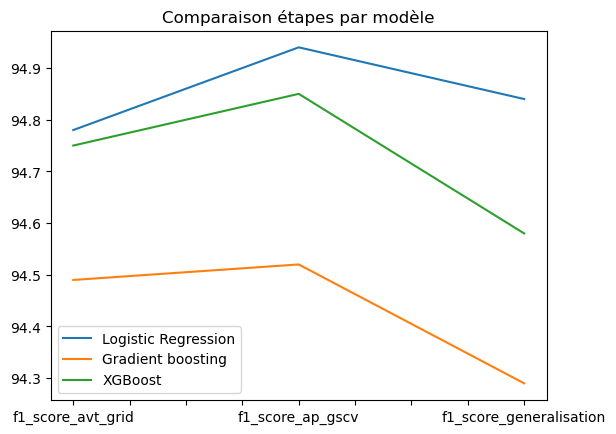

In [47]:
# Graphique représentant les résultats des 3 étapes 
comparaison_etapes_T.plot(title="Comparaison étapes par modèle")

La régression logistique reste le meilleur modèle pour chaque étape. Nous allons donc analyser les variables de ce modèle.

### <span style="color:#011C5D">3.7. Prediction et interprétation Regression logistique optimisée</span>

#### <span style="color:#011C5D">Prédiction</span>

In [48]:
pipe_gscv_lr.best_params_

{'classifier__C': 1,
 'classifier__max_iter': 500,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [49]:
best_clf = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', LogisticRegression(C = pipe_gscv_lr.best_params_["classifier__C"],
                                          penalty = pipe_gscv_lr.best_params_["classifier__penalty"],
                                          max_iter = pipe_gscv_lr.best_params_["classifier__max_iter"],
                                          solver = pipe_gscv_lr.best_params_["classifier__solver"],
                                          random_state=SEED))
    ])

best_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_code',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000029557F7C0D0>),
                                                 ('numerical_var',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000029557F7C820>),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000

In [50]:
y_train_pred_lr = best_clf.predict(X_train)

In [51]:
# classification_report - jeu de train

target_names_train = ['class 0', 'class 1',]
print(classification_report(y_train, y_train_pred_lr, target_names=target_names_train))

              precision    recall  f1-score   support

     class 0       0.84      0.69      0.76       437
     class 1       0.94      0.97      0.95      2054

    accuracy                           0.92      2491
   macro avg       0.89      0.83      0.86      2491
weighted avg       0.92      0.92      0.92      2491



#### <span style="color:#011C5D">Interprétation</span>

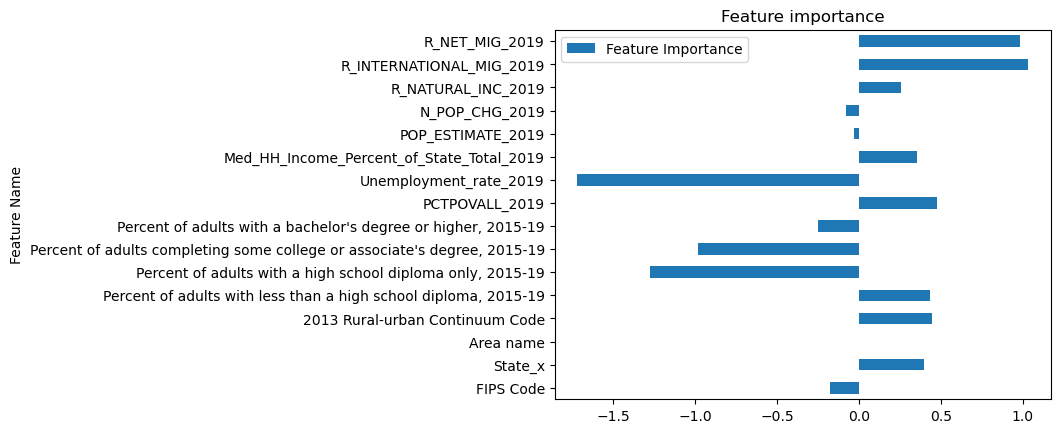

In [52]:
# Analyse Features importance

def display_feat_imp_reg(reg):
  feat_imp_reg = best_clf['classifier'].coef_[0]
  reg_feat_importance = pd.DataFrame(columns=["Feature Name", "Feature Importance"])
  reg_feat_importance["Feature Name"] = pd.Series(reg.feature_names_in_)
  reg_feat_importance["Feature Importance"] = pd.Series(feat_imp_reg)
  reg_feat_importance.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance")
 
display_feat_imp_reg(best_clf)

In [53]:
# Analyse importance des coeff

#récuperation coef
best_clf_coef = best_clf[-1].coef_.T

#recuperation name features
feature_names = best_clf[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    best_clf_coef,
    columns=["Coefficients"],
    index=feature_names,
)

coefs

,Coefficients
numerical_code__FIPS Code,-0.175345
numerical_var__2013 Rural-urban Continuum Code,0.399803
"numerical_var__Percent of adults with less than a high school diploma, 2015-19",0.000000
"numerical_var__Percent of adults with a high school diploma only, 2015-19",0.446024
"numerical_var__Percent of adults completing some college or associate's degree, 2015-19",0.435643
...,...
categorical__Area name_Yolo County,0.000000
categorical__Area name_York County,0.000000
categorical__Area name_Yuba County,0.000000
categorical__Area name_Yuma County,0.000000


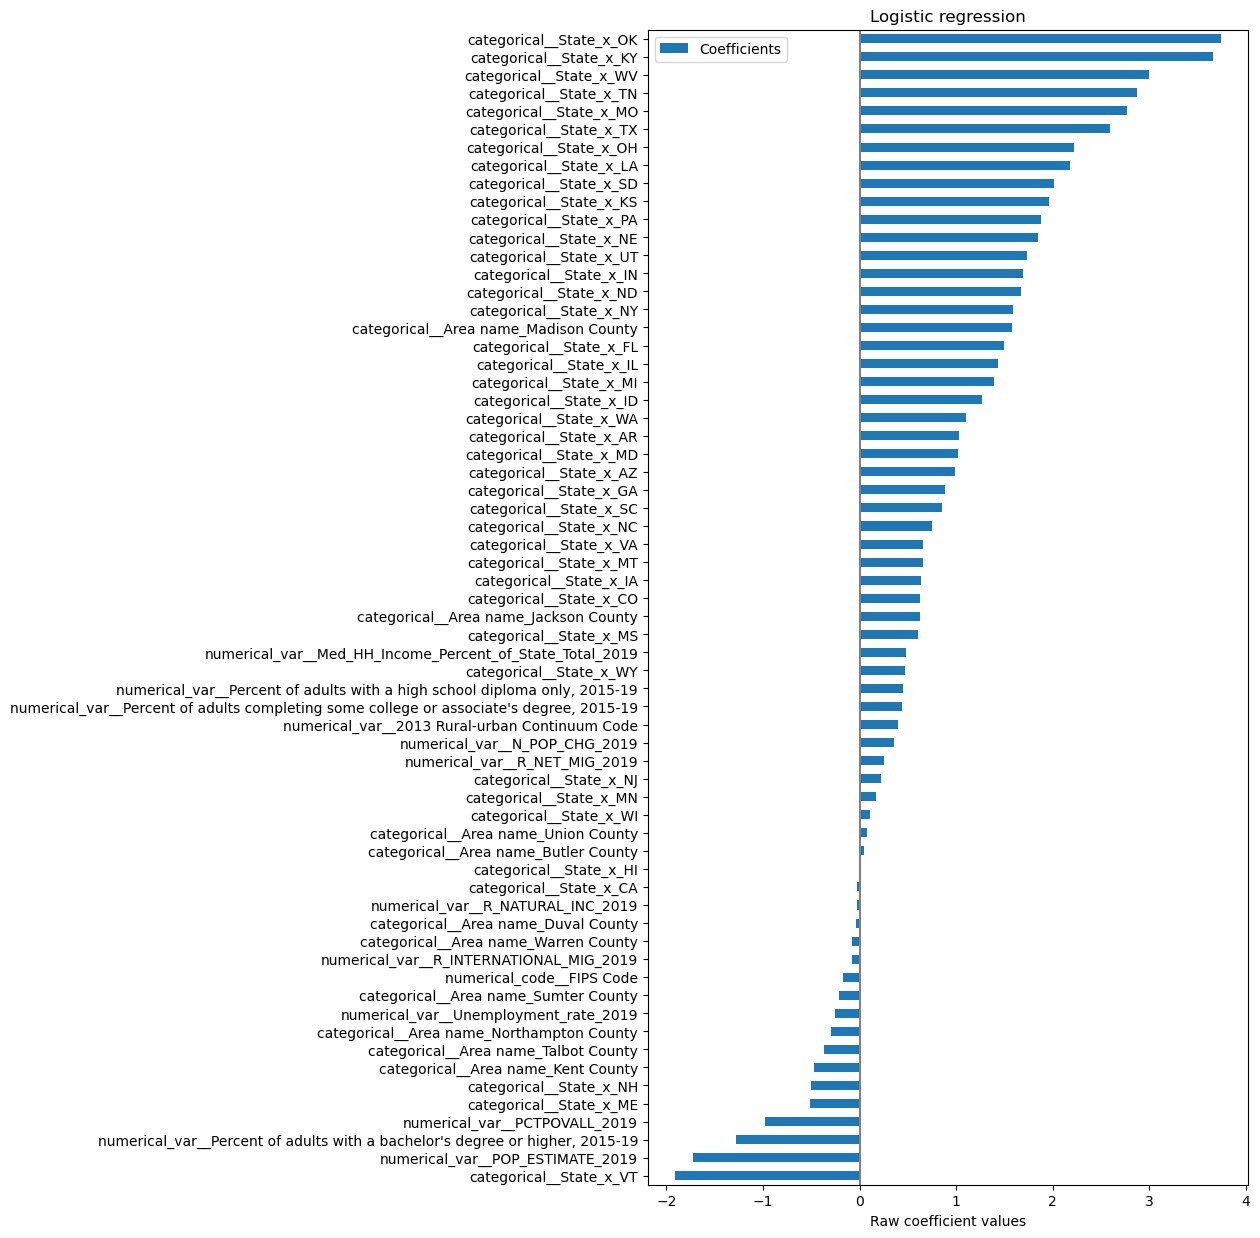

In [54]:
# Représentation importance des coeff

coefs[coefs['Coefficients'] != 0].sort_values(by = "Coefficients", ascending = True).plot(kind='barh', figsize=(10, 15))
plt.title('Logistic regression')
plt.axvline(x=0, color='.5')
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=.3)

Nous pouvons voir que l'Etat de résidence influe complètement sur le vote. <br>
Les citoyens de certains Etats comme l'Oklahoma (OK), le Kentucky (KY) ou encore dans le Tennessee (TN) voteront presque toujours pour les Republicains. <br>
A contrario, le Vermont (VT), le Maine (ME) ou la Californie (CA) voteront pour les Democrates. <br>
Le taux de pauvreté va également influencer le vote : plus il sera élevé, plus le vote ira vers les Democrates. Même chose pour le taux de chômage. <br>
En revanche, plus le niveau de diplôme est élevé, plus le vote ira aux Républicains. <br>
Les gens les plus "aisés" voteront plus pour les Républicains également.

### <span style="color:#011C5D">3.8. Evaluation finale</span>

In [55]:
df_2019_pct_test = pd.read_csv('data\outputs\df_2019_pct_test.csv', sep=',')
df_2019_pct_test.head()

,FIPS Code,State_x,Area name,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults completing some college or associate's degree, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",PCTPOVALL_2019,...,N_POP_CHG_2019,RESIDUAL_2019,GQ_ESTIMATES_2019,R_birth_2019,R_death_2019,R_NATURAL_INC_2019,R_INTERNATIONAL_MIG_2019,R_DOMESTIC_MIG_2019,R_NET_MIG_2019,target
0,17133,IL,Monroe County,1.0,1.0,4.034129,27.642479,33.283630,35.039761,4.2,...,264.0,-3.0,344.0,10.404289,9.245037,1.159252,0.000000,6.578757,6.578757,1.0
1,17077,IL,Jackson County,3.0,2.0,8.104560,24.073969,33.705269,34.116203,25.4,...,-539.0,4.0,3586.0,10.768246,8.698778,2.069467,3.226966,-14.819492,-11.592525,0.0
2,30097,MT,Sweet Grass County,9.0,12.0,5.431193,36.587154,32.623852,25.357798,10.3,...,34.0,0.0,45.0,9.139785,8.870968,0.268817,0.537634,8.333333,8.870968,1.0
3,6075,CA,San Francisco County,1.0,1.0,11.534667,12.051112,18.353155,58.061066,9.5,...,853.0,-60.0,24242.0,10.064435,7.216931,2.847504,5.104852,-6.916178,-1.811326,0.0
4,30067,MT,Park County,7.0,9.0,5.507154,29.917673,33.122852,31.452322,11.8,...,-42.0,-2.0,108.0,9.262044,9.983761,-0.721718,-0.240573,-1.443435,-1.684008,1.0


In [56]:
#jeu de test pour évaluation finale : df_2019_pct_test
#application des memes modif que sur le jeu de train

df_2019_pct_test2 = df_2019_pct_test.drop(df_2019_pct_test[(df_2019_pct_test["State_x"]=='PR')].index)
df_target_clean_test = df_2019_pct_test2.drop(df_2019_pct_test2[(df_2019_pct_test2["target"].isna())].index)
df_target_clean_test.reset_index(drop=True, inplace=True)

df_target_clean_drop = ['2013 Urban Influence Code', 'CI90LBALLP_2019', 'CI90UBALLP_2019', 'PCTPOV017_2019', 'CI90LB017P_2019', 'CI90UB017P_2019','PCTPOV517_2019', 'CI90LB517P_2019', 
                        'CI90UB517P_2019', 'CI90LBINC_2019', 'CI90UBINC_2019', 'Metro_2013', 'Civilian_labor_force_2019', 'Employed_2019', 'Unemployed_2019', 'Median_Household_Income_2019', 
                        'Economic_typology_2015','RESIDUAL_2019', 'GQ_ESTIMATES_2019', 'R_birth_2019', 'R_death_2019','R_DOMESTIC_MIG_2019']

df_test_prepro = df_target_clean_test.drop(columns=df_target_clean_drop, axis=1)

In [57]:
df_test_prepro.head()

,FIPS Code,State_x,Area name,2013 Rural-urban Continuum Code,"Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults completing some college or associate's degree, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",PCTPOVALL_2019,Unemployment_rate_2019,Med_HH_Income_Percent_of_State_Total_2019,POP_ESTIMATE_2019,N_POP_CHG_2019,R_NATURAL_INC_2019,R_INTERNATIONAL_MIG_2019,R_NET_MIG_2019,target
0,17133,IL,Monroe County,1.0,4.034129,27.642479,33.283630,35.039761,4.2,3.1,131.341385,34637.0,264.0,1.159252,0.000000,6.578757,1.0
1,17077,IL,Jackson County,3.0,8.104560,24.073969,33.705269,34.116203,25.4,3.8,53.903946,56750.0,-539.0,2.069467,3.226966,-11.592525,0.0
2,30097,MT,Sweet Grass County,9.0,5.431193,36.587154,32.623852,25.357798,10.3,2.8,96.525642,3737.0,34.0,0.268817,0.537634,8.870968,1.0
3,6075,CA,San Francisco County,1.0,11.534667,12.051112,18.353155,58.061066,9.5,2.2,151.442993,881549.0,853.0,2.847504,5.104852,-1.811326,0.0
4,30067,MT,Park County,7.0,5.507154,29.917673,33.122852,31.452322,11.8,3.4,90.378700,16606.0,-42.0,-0.721718,-0.240573,-1.684008,1.0


In [58]:
df_test_prepro['target'].value_counts(normalize=True)

1.0    0.837359
0.0    0.162641
Name: target, dtype: float64

In [59]:
df_test_prepro['State_x'].value_counts()

TX    50
GA    32
VA    26
KY    24
MO    23
KS    21
IA    20
IL    20
NC    20
NE    19
TN    19
MN    18
IN    18
OH    17
MS    17
MI    17
OK    16
WI    15
AR    14
FL    14
PA    14
AL    14
NY    13
SD    13
LA    12
CA    12
CO    12
ND    11
WV    11
MT    11
SC     9
WA     8
ID     8
NM     7
OR     7
MD     5
UT     5
WY     4
NJ     4
MA     3
ME     3
NV     3
AZ     3
VT     2
CT     2
NH     2
DE     1
RI     1
HI     1
Name: State_x, dtype: int64

In [60]:
y_test = df_test_prepro['target'].values
X_test = df_test_prepro.drop(columns=['target'])

In [61]:
best_clf = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', LogisticRegression(C = pipe_gscv_lr.best_params_["classifier__C"],
                                          penalty = pipe_gscv_lr.best_params_["classifier__penalty"],
                                          max_iter = pipe_gscv_lr.best_params_["classifier__max_iter"],
                                          solver = pipe_gscv_lr.best_params_["classifier__solver"],
                                          random_state=SEED))
    ])

best_clf.fit(X_test, y_test)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_code',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000029557F7C0D0>),
                                                 ('numerical_var',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000029557F7C820>),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000

In [62]:
y_test_pred = best_clf.predict(X_test)

print(f"Le score F1 sur le jeu de test est de {round(f1_score(y_test, y_test_pred)*100,2)} %")

Le score F1 sur le jeu de test est de 95.1 %


In [63]:
# classification_report - jeu de test

target_names = ['class 0', 'class 1',]
print(classification_report(y_test, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.81      0.63      0.71       101
     class 1       0.93      0.97      0.95       520

    accuracy                           0.92       621
   macro avg       0.87      0.80      0.83       621
weighted avg       0.91      0.92      0.91       621



Conclusion : <br> 
Le modèle prédit mieux la classe des Républicains (class 1) que celle des Démocrates